## Data Augmentation

Bara here
- i would like to not change the speed of the audio because the speed at which people talk can change depending on the accent and i don't think we should be chnaging smething that can be a learnable parameter for the NN
- for pitch i think that too is a accent dependent parameter. tho idk

- i think adding noise is both good and realistic for generalization purposes
- i also think we should do the silence deletion


In [2]:
#load data
import convenience

df_train_val, sample_rates = convenience.load_train()
df_train_val['augmented_data'] = df_train_val.audio
df_train_val.head()

,file_name,stratify,accent,gender,audio,length,augmented_data
0,1f_1018.wav,1f,1,f,"[tensor(-0.0002), tensor(-6.1035e-05), tensor(...",3.413312,"[tensor(-0.0002), tensor(-6.1035e-05), tensor(..."
1,1f_1026.wav,1f,1,f,"[tensor(-0.0008), tensor(-0.0008), tensor(-0.0...",5.632000,"[tensor(-0.0008), tensor(-0.0008), tensor(-0.0..."
2,1f_1031.wav,1f,1,f,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",4.693313,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0..."
3,1f_1070.wav,1f,1,f,"[tensor(0.0022), tensor(0.0019), tensor(0.0018...",3.925312,"[tensor(0.0022), tensor(0.0019), tensor(0.0018..."
4,1f_1075.wav,1f,1,f,"[tensor(0.), tensor(3.0518e-05), tensor(0.), t...",2.737500,"[tensor(0.), tensor(3.0518e-05), tensor(0.), t..."


In [3]:
sr = list(sample_rates)[0]
sr

#initialize sr variable (sampling rate) 

16000

In [4]:
import torch
import pandas as pd

In [5]:
waveform = df_train_val.audio[0]
print(waveform)
waveform.shape

tensor([-2.1362e-04, -6.1035e-05, -3.0518e-05,  ...,  6.4087e-04,
         7.3242e-04,  5.7983e-04])


torch.Size([54613])

#### Librosa

In this part I apply different types of augmentation techniques. They're programmed in a pipeline, where the output of the previous is the input to the next one. 
If you want to apply the augmentation technique to a 'clean slate', apply it to df_train_val['augmented'].

Code is adapted from: https://www.kaggle.com/code/huseinzol05/sound-augmentation-librosa#apply-hpss 

(Please note it would be a good idea to see for which augmentations the model has the best performance, yet also a good generalizability!)

In [6]:
import numpy as np
import librosa 

import seaborn as sns 
sns.set() #iirc mostly for visuals 
import tensorflow as tf
from IPython.display import Audio

In [7]:
#pitch shifted audio
#This is the begining of the pipeline, so df_train_val is used. 
pitch_shift_audio = [] #I always create a seperate list to avoid overwriting the original variable
for file in df_train_val['augmented_data']:
    audio_pitch = file.numpy() #data has to be a numpy array for Librosa to work
    bins_per_octave = 12 
    pitch_pm = 2 
    pitch_change =  pitch_pm * 2*(np.random.uniform())  #every audiofile has a random pitch change (can be tweaked)
    
    pitch_shift_audio.append(librosa.effects.pitch_shift(audio_pitch, sr = 16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)) 

print(pitch_shift_audio)

[array([-1.6103678e-04, -6.1002756e-05,  3.3101194e-06, ...,
        2.3390412e-04,  2.1695538e-04,  2.5044230e-04], dtype=float32), array([-0.00066394, -0.00084386, -0.00077629, ...,  0.00012591,
        0.00015067,  0.00015756], dtype=float32), array([-2.1498918e-04, -2.1749127e-04, -1.4017121e-04, ...,
        1.5431813e-05,  5.3831824e-05,  3.7550486e-05], dtype=float32), array([ 1.99760520e-03,  1.96802174e-03,  1.72356726e-03, ...,
       -1.10846006e-04, -1.31580993e-04, -9.77652235e-05], dtype=float32), array([ 3.9411011e-06,  2.6698131e-05, -4.0888481e-06, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32), array([-5.5919855e-04, -5.9710909e-04, -5.2115356e-04, ...,
        7.5034026e-05,  1.4338747e-04,  7.9048390e-05], dtype=float32), array([-9.9008076e-08,  7.3574233e-07, -1.7522685e-06, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32), array([-4.1922808e-04, -3.1622412e-04, -4.4896547e-04, ...,
        8.1984464e-05,  8.1

In [8]:
type(pitch_shift_audio[2])

numpy.ndarray

In [9]:
#change speed
#notice how pitch_shift_audio is the input for this part (so no .numpy needed anymore)
speed_shift_audio = []
for file in pitch_shift_audio:
    audio_speed = file 
    speed_change = np.random.uniform(low=0.9,high=1.1) #strength of the effect (can be tweaked)
    tmp = librosa.effects.time_stretch(audio_speed, rate = speed_change) 
    minlen = min(audio_speed.shape[0], tmp.shape[0])
    audio_speed *= 0 
    audio_speed [0:minlen] = tmp[0:minlen] 
    
    speed_shift_audio.append(audio_speed)

In [10]:
#distribution noise
noise_dist_audio = []

for file in speed_shift_audio:
    audio_noise = file
    noise_amp = 0.005*np.random.uniform()*np.amax(audio_noise) #random audio noise, can be changed to any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    audio_noise = audio_noise + noise_amp * np.random.normal(size= audio_noise.shape[0]) #mathy math for noise
    
    noise_dist_audio.append(audio_noise) 

In [22]:
#random shift
rand_shift_audio = []

for file in noise_dist_audio:
    audio_shift = file
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length shift (can be tweaked)
    start = int(audio_shift.shape[0] * timeshift_fac)
    if (start > 0): 
        audio_shift = np.pad(audio_shift,(start,0),mode='constant')[0:audio_shift.shape[0]]
    else:
        audio_shift = np.pad(audio_shift,(0,-start),mode='constant')[0:audio_shift.shape[0]]
    Audio(audio_shift, rate= sr)
    
    rand_shift_audio.append(audio_shift)

In [12]:
#stretching
stretch_shift_audio = []

for file in rand_shift_audio:
    input_length = len(file)
    streching = file
    streching = librosa.effects.time_stretch(streching , rate = 1.1) #similar code to speed up due to file needing to fit audio
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")

    stretch_shift_audio.append(streching)

In [13]:
#silence cutting
trimmed_audio = []

for file in stretch_shift_audio:
    trimmed, index = librosa.effects.trim(file, top_db = 20)
    trimmed_audio.append(trimmed)

Axes(0.125,0.11;0.775x0.77)


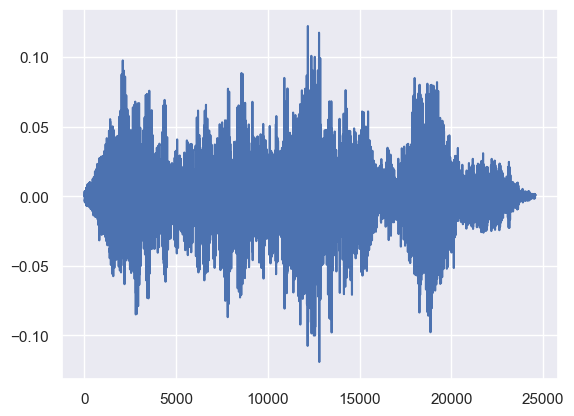

In [14]:
#seeing how the audio looks like
#sanity check to see if the trimming works
print(pd.Series(trimmed_audio[1000]).plot())

In [24]:
#this is testing how does any data point sound after the augmentation.

import IPython.display as ipd
#df_train_val.audio
#pitch_shift_audio
#speed_shift_audio
#noise_dist_audio
#rand_shift_audio
#stretch_shift_audio
#trimmed_audio


ipd.Audio(stretch_shift_audio[1000], rate=16000)

#I will point out that by cutting off the silence, we have yet again made our audio signals widely different lengths
#also the speech is basically unrecognisable

In [35]:
#supposed to convert the augmented data back into the df, in tensor form, but I was unable to make it work, kept giving dimension errors
#there could be a hidden issue in the functions used where it changes the dimensions, I suspect speed or stretch 
#I would try to run all parts of the pipeline seperately and see from where the issue arrises 

##Bara here! I think the issue is because you're converting a list on np arrays, which i dont think the .tensor hnows how to handle?

#augmented_data = torch.tensor(trimmed_audio)

#df_train_val['augmented_data'] = augmented_data
#df_train_val.head()